Hello Kagglers!! This week was totally boring, so in order to cheer up myself, I wanted to put up a new kernel with some cool stuff. I know ..I know...I know autoencoders aren't something new but for some people, they are  a big deal, especially for people new to the field of deep learning. Well, without saying anything further, let's dive in and try to build an autoencoder in Keras.
![Autoenoders, hell yeah!!](https://media.giphy.com/media/NL6i0bK8omoMM/giphy.gif)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import os
from pathlib import Path
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adagrad
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
np.random.seed(111)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
# Any results you write to the current directory are saved as output.

In [2]:
# Define paths in the fancy way, after all we have pathlib now. No more os.path.join...whatever!!
input_dir  = Path('input/')
train = input_dir / 'train'
train_cleaned = input_dir / 'train_cleaned'
test = input_dir / 'test'

Total number of images in the training set:  144
Total number of cleaned images found:  144
Total number of samples in the test set:  72


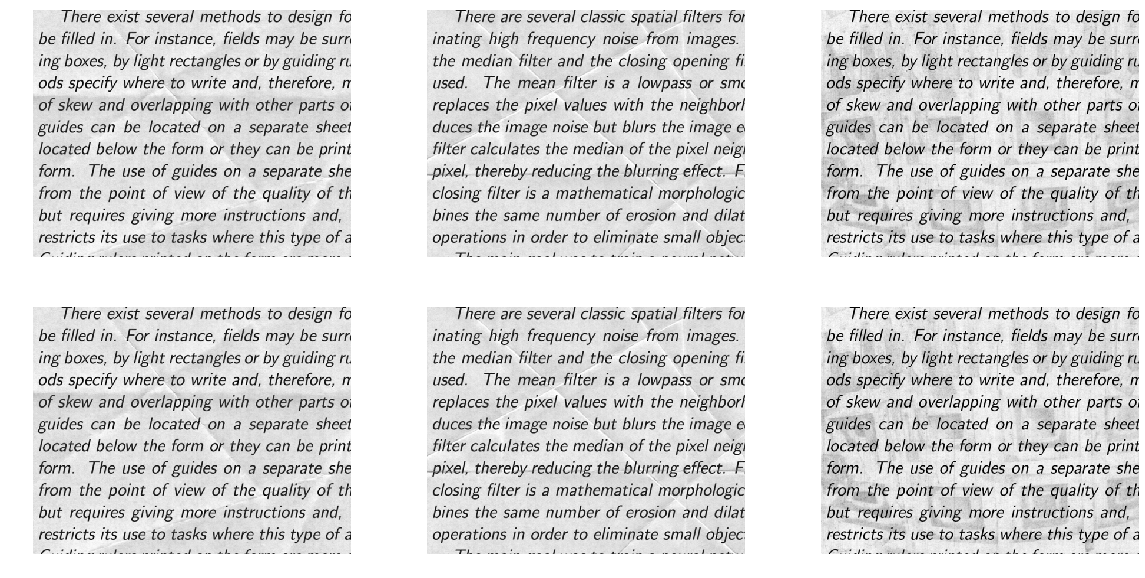

In [3]:
# The train directory comtaims png files. Let's get all the files and check a few samples
train_images = sorted(os.listdir(str(train)))
train_labels = sorted(os.listdir(str(train_cleaned)))
test_images = sorted(os.listdir(str(test)))
print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))
print("Total number of samples in the test set: ", len(test_images))

# Lets' plot a few samples
# First row will be raw data, second row will be the corresponding cleaned images
samples = train_images[:3] + train_labels[:3]

f, ax = plt.subplots(2, 3, figsize=(20,10))
for i, img in enumerate(samples):
    img = imread(train/img)
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].axis('off')
plt.show()    

In [40]:
# Lets' define our autoencoder now
def build_autoenocder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #enoder 
    x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
#     x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
#     x = MaxPooling2D((2,2), padding='same')(x)
#     x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
#     x = MaxPooling2D((2,2), padding='same')(x)
    
    #decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
#     x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
#     x = UpSampling2D((2,2))(x)
#     x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
#     x = UpSampling2D((2,2))(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return autoencoder

In [41]:
autoencoder = build_autoenocder()
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 420, 540, 1)]     0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 420, 540, 32)      320       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 210, 270, 32)      0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 210, 270, 64)      18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 105, 135, 64)      0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 105, 135, 64)      36928     
_________________________________________________________________
up_sampling2d_24 (UpSampling (None, 210, 270, 64)      0   

The dataset is small, so we can actually store the numpy arrays of images and corresponding cleaned images numpy arrays into two numpy arrays (Ha!! a lot of `numpy` and `array` in a single sentence). This would eliminate the need for defining a generator. 

In [42]:
X = []
Y = []

for img in train_images:
    img = load_img(train / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(train_cleaned / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)

Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)


In [43]:
# Split the dataset into training and validation. Always set the random state!!
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)


In [44]:
# Train your model
autoencoder.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_valid, y_valid))

Train on 129 samples, validate on 15 samples
Epoch 1/10
  8/129 [>.............................] - ETA: 4:13

KeyboardInterrupt: 

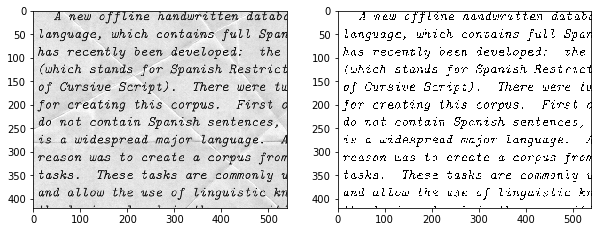

In [9]:
# Let's test our model on a sample test image
sample_test = load_img(test/ test_images[10], grayscale=True, target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()

Not bad!! I just trained this model for 10 epochs becuase Kaggle kernels don't come with a GPU. But you can see that it's clearly going in the right direction. 

### Tips:
* Download the dataset, upload to your Gdrive. Use Colab...FREE GPU!!!
* Make a **deeeppeerr** model
* Avoid Adam, it's too aggressive for this task (I might be wrong)


Upvote the kernel if you liked it. Also, if you found anything wrong in the notebook or if you want to suggest something as an improvement, please do share that in the comments section. I hope you enjoyed the kernel.